In [ ]:
# To install matlab, run pip install matlab
# To install matlab engine, run pip install 'matlabengine == 9.13.7'

import numpy as np
import torch
from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import FastICA

from Models import BG

import os
os.makedirs("estimates", exist_ok=True)


True
NVIDIA GeForce RTX 4070 Laptop GPU


In [ ]:
mat = loadmat('tsd180.mat')
d = mat['days']
p = mat['pm']
n = mat['nmss']
[N,M] = np.shape(p)

Data = pd.DataFrame({'days': d[:,0]})
for i in range(M):
    Datai = pd.DataFrame({n[i,0][0] : p[:,i]})
    Data = pd.concat([Data,Datai],axis=1)

DataETFs = Data[['spy', 'xle', 'xlf', 'xli', 'xlk', 'xlp', 'xlu', 'xlv', 'xly', 'xom', 'xrx']]
DataETFsReturns = DataETFs.diff()
DataETFsReturns = DataETFsReturns.drop(index = 0)
DataETFsReturns.insert(0, 'days', d[1:])
DataETFs.insert(0, 'days', d)
DataETFsReturns['days'] = pd.to_datetime(DataETFsReturns['days'], format='%Y%m%d')

X = DataETFsReturns.iloc[:,1:].values
T, N = X.shape
all_params = np.full((T, N, 4), np.nan) 

#DataETFs.head(10)
print(X.shape)
print(X)

(4430, 11)
[[ 0.63    0.0485  0.1218 ...  0.08   -0.59    0.7377]
 [-0.14   -0.6117 -0.0244 ...  0.19   -0.56   -0.1317]
 [ 0.48   -0.8739  0.1218 ...  0.21   -1.1     0.    ]
 ...
 [ 0.86   -0.38    0.12   ...  0.62   -0.48    0.13  ]
 [ 0.18   -1.3     0.11   ... -0.94   -1.47   -0.36  ]
 [-1.38   -0.19   -0.12   ... -1.11   -0.21   -0.25  ]]


In [ ]:
# 1) Build one BG instance
bg = BG(N=2**14, B=300000)

# 2) Fit SPY (column 0) *serially* (no per-window parallel):
# spy_params = bg.fit_series(X[:, 0], window=100)
# print("SPY params shape:", spy_params.shape)
# print("Example SPY at t=150:", spy_params[150, :])

# # 3) Fit all 11 assets *in parallel across assets* (1 process per asset):
# all_params = bg.fit_multiple(X, window=100, n_workers=11)
# print("All params shape:", all_params.shape)
# print("Example (t=150, asset=3):", all_params[150, 3, :])

# 4) Fit all 11 assets *in parallel across windows* (1 process per window):
for i in range(N):
    print(f"Fitting asset {i+1}/{N}...")
    all_params[:, i, :] = bg.fit_series_parallel(series=X[:, i], window=100, bg_model=bg, n_jobs=-1)

np.save("estimates/all_params.npy", all_params)

: 

: 

In [4]:
import os
import numpy as np

# Create the folder if it doesn't exist
os.makedirs('estimates', exist_ok=True)

# Save the array
np.save('estimates/all_params.npy', all_params)

# To load it later:
# loaded_params = np.load('estimates/all_params.npy')

NameError: name 'all_params' is not defined

In [3]:
loaded_params = np.load('estimates/all_params.npy')
print("Example (t=0, asset=3):", loaded_params[100, 3, :])

Example (t=0, asset=3): [6.88027852e-04 2.00245159e+00 8.55540460e-04 2.16041611e+00]


estimated [bp,cp,bn,cn] at time t = 0: [0.0023744  2.18318017 0.00320532 1.9000456 ]


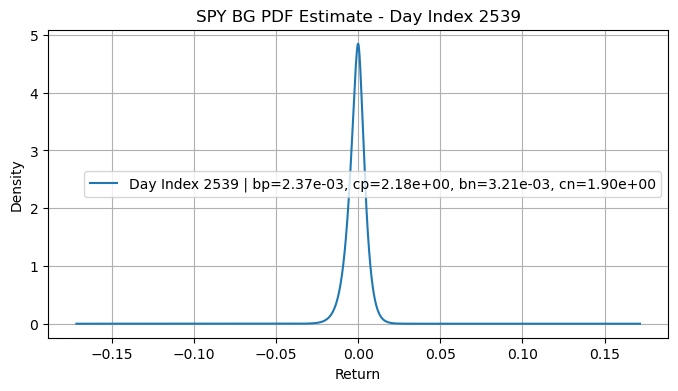

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import gamma

bg = BG(N=2**14, B=300000)
# Load the BG parameter estimates file
estimates_path = "estimates/all_params.npy"
estimates_array = np.load(estimates_path, allow_pickle=True)

# Identify valid rows (non-NaN)
valid_days = ~np.isnan(estimates_array).all(axis=(1, 2))
valid_indices = np.where(valid_days)[0]

# Randomly select 5 valid days
np.random.seed(42)
random_days = np.random.choice(valid_indices, size=5, replace=False)

# Plot estimated BG PDFs for SPY (assumed to be at index 0)
t = 2539
params = loaded_params[100+t, 0, :]  # index 0 = SPY
print(f"estimated [bp,cp,bn,cn] at time t = {0}: {params}")

pdf_vals = bg.pdf(theta=params)

plt.figure(figsize=(8, 4))
plt.plot(bg.x, pdf_vals, label=f'Day Index {t} | bp={params[0]:.2e}, cp={params[1]:.2e}, bn={params[2]:.2e}, cn={params[3]:.2e}')
plt.title(f'SPY BG PDF Estimate - Day Index {t}')
plt.xlabel('Return')
plt.ylabel('Density')
plt.grid(True)
plt.legend()
plt.show()


In [9]:
print(params)

[0.00766985 2.00020046 0.00837479 1.99977389]


In [4]:
import matplotlib.pyplot as plt
import torch

def plot_bg_pdfs(bg_model, theta_batch, pdfs=None):
    """
    Plot a batch of BG PDFs.
    
    Parameters:
    - bg_model: the BG model object (already instantiated)
    - theta_batch: torch.Tensor of shape (B, 4)
    - pdfs: optional, precomputed tensor of shape (B, N)
    """
    B = theta_batch.shape[0]

    if pdfs is None:
        pdfs = bg_model.pdf(theta_batch)

    x = bg_model.x.cpu().numpy() if isinstance(bg_model.x, torch.Tensor) else bg_model.x

    for i in range(B):
        theta = theta_batch[i].cpu().numpy()
        label = f"bp={theta[0]:.2e}, cp={theta[1]:.2e}, bn={theta[2]:.2e}, cn={theta[3]:.2e}"

        plt.figure(figsize=(8, 4))
        plt.plot(x, pdfs[i].cpu().numpy(), label=label)
        plt.title(f'BG PDF Estimate - Sample {i}')
        plt.xlabel('Return')
        plt.ylabel('Density')
        plt.grid(True)
        plt.legend()
        plt.tight_layout()
        plt.show()


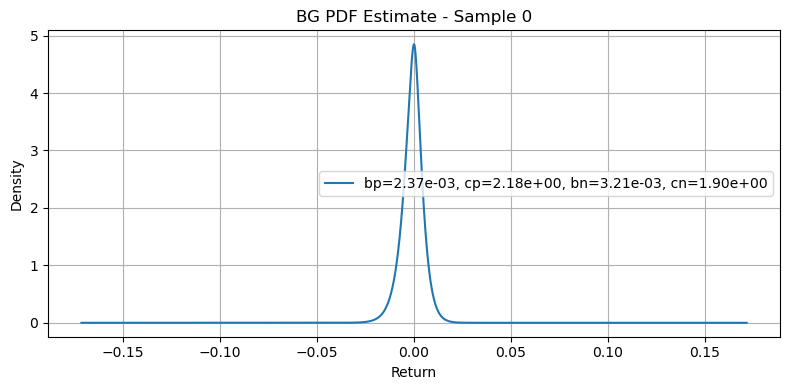

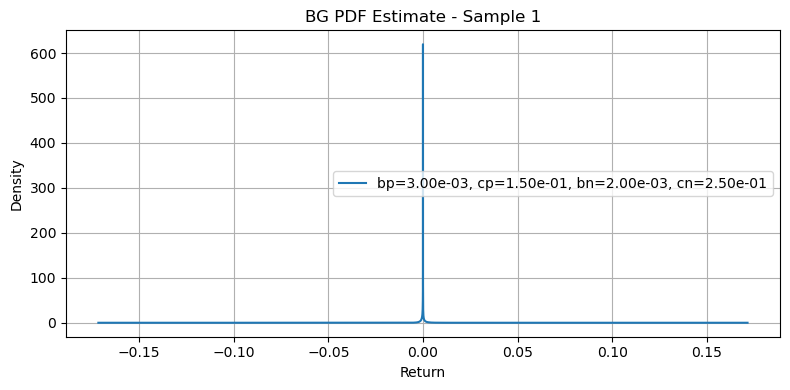

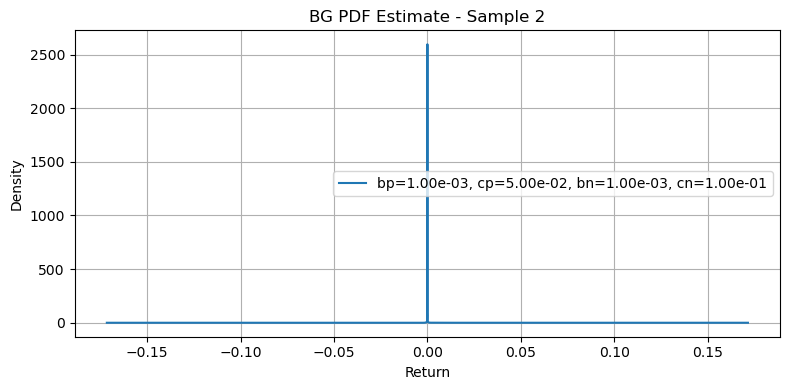

In [5]:
theta_batch = torch.tensor([
    [0.0023744, 2.18318017, 0.00320532, 1.9000456],
    [3e-3, 0.15, 2e-3, 0.25],
    [1e-3, 0.05, 1e-3, 0.1]
], dtype=torch.float32).to('cuda')

bg_gpu = BG(N=2**14, B=300000, device='cuda')
pdfs = bg_gpu.pdf(theta_batch)  # shape: [3, 4096]

plot_bg_pdfs(bg_gpu, theta_batch, pdfs)

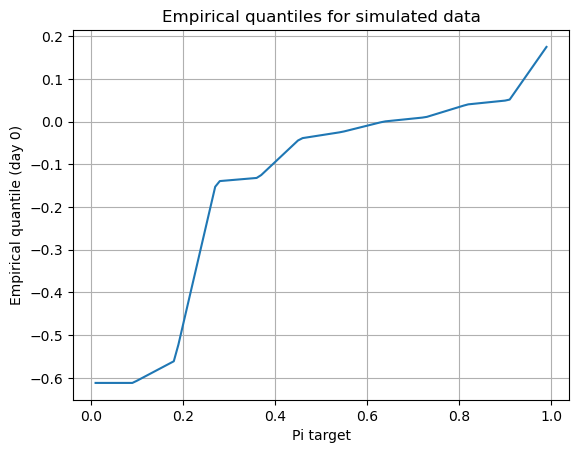

In [14]:
# Make sure you run this on a GPU-enabled environment
test_returns = X[0:2,:]
Pi_target, s_i_batch = bg_gpu.empirical_quantiles_numpy(test_returns)

# Example: plot Day 0
import matplotlib.pyplot as plt
plt.plot(Pi_target, s_i_batch[1])
plt.xlabel('Pi target')
plt.ylabel('Empirical quantile (day 0)')
plt.title('Empirical quantiles for simulated data')
plt.grid()
plt.show()


In [ ]:
import torch
import matplotlib.pyplot as plt
from Models import BG

# 1. Create model and load s_batch
bg_gpu = BG(N=2**14, B=300000, device='cuda')
bg_gpu.s_batch = torch.load("estimates/empirical_quantiles.pt")  # shape (T, K), CUDA
Q_emp = bg_gpu.s_batch  # alias

# 2. Define Pi_target (x-axis)
Pi_target = torch.linspace(0.01, 0.99, 99).to('cuda')  # same as used in empirical quantiles

# 3. Create theta_batch for 2 days (or use learned values)
theta_batch = torch.tensor([
    [0.0023744, 2.18318017, 0.00320532, 1.9000456],
    [3e-3, 0.15, 2e-3, 0.25]
], dtype=torch.float32, requires_grad=True).to('cuda')

# 4. Compute theoretical quantiles
Q_model = bg_gpu.theoretical_quantiles(theta_batch)

# 5. Plot Day 0
plt.figure(figsize=(8, 4))
plt.plot(Pi_target.cpu(), Q_emp[0].cpu(), label='Empirical Quantiles (day 0)', lw=2)
plt.plot(Pi_target.cpu(), Q_model[0].detach().cpu(), label='Theoretical Quantiles (day 0)', lw=2, linestyle='--')
plt.xlabel('Pi_target')
plt.ylabel('Quantile Value')
plt.title('Empirical vs Theoretical Quantiles (day 0)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

